### Flexible interface

Previously we have shown a couple of examples of how to use `sbi` package as a one-liner. Here we are going to discuss he flexible interface of the package, which might be useful for customizing the code to fit a particular problem

Within this block we are going to discuss:

- performing sequential posterior estimation by focusing on a particular observation over multiple rounds. This can decrease the number of simulations one has to run, but the inference procedure is no longer amortized .    
- specify your own density estimator, or change hyperparameters of existing ones (e.g. number of hidden units for [NSF](https://arxiv.org/abs/1906.04032)).    
- methods of crafting summary statistics instead of using the whole simulation as an input to neural network
- parallelisation over multiple workers on the same node or multiple nodes

### Text messaging example

Let us re-run the Text messaging example using flexible interface and attempt to change some parameters. We do necessary imports and load our dataset

In [2]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.utils import MultipleIndependent
import numpy as np


/p/software/jusuf/stages/2024/software/tqdm/4.66.1-GCCcore-12.3.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


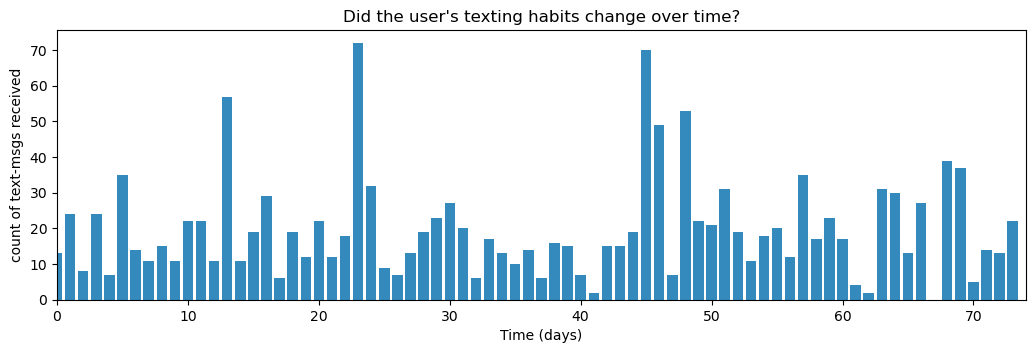

In [1]:
import scipy.stats as stats
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt


figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

We leave the definitions of simulator and prior as before

In [3]:
def simulator(params):
        data = np.r_[stats.poisson.rvs(mu=params[0], size=int(params[2])), stats.poisson.rvs(mu=params[1], size=74 - int(params[2]))]
        return data
    

alpha=1./20.    
prior_cpu=MultipleIndependent(
    [
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Uniform(low=torch.Tensor([0]),high=torch.Tensor([70]))
    ]
)

In the flexible interface, one has to ensure that your simulator and prior adhere the requirements of `sbi`. This is done with the `prepare_for_sbi()` function.

In [4]:
simulator, prior = prepare_for_sbi(simulator, prior)

In order instantiate the inference object call one of the functions `SNPE`, `SNRE`, `SNLE` from `sbi.inference`. Note, that we can also customize the density estumator, namely the neural network used to build an approximate posterior/likelihood/likelihood ratio. More information on the available networks can be found in `sbi/utils/get_nn_models.py`. It is also possible to implement your own density estimator from scratch, e.g., including embedding nets to preprocess data, or to a density estimator architecture of your choice. 

For this, the `density_estimator` argument needs to be a function that takes `theta` and `x` batches as arguments to then construct the density estimator after the first set of simulations was generated.

In the code below we will replace the default value `maf` (mean autoregressiv flow) for `density_estimator` with `nsf` (neural spline flow)

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    prior_gpu=MultipleIndependent(
    [
        torch.distributions.Exponential(rate=torch.ones(1,device=device)*0.05),
        torch.distributions.Exponential(rate=torch.ones(1,device=device)*0.05),
        torch.distributions.Uniform(low=torch.Tensor([0],device=device),high=torch.Tensor([70],device=device))
    ]
)
    prior=prior_gpu
else:
    device = torch.device('cpu')
    prior=prior_cpu

#inference = SNRE(prior=prior, classifier="resnet")

Going into finer details there is also an option of configuring the density estimator choosing the number of hidden features, transforms etc.  More details on hyperparameters can be found at `sbi/neural_nets` 
`

In [6]:
from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNLE: likelihood_nn(). For SNRE: classifier_nn()

density_estimator_build_fun = posterior_nn(
    model="nsf", hidden_features=60, num_transforms=3
)
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun,device=device)

Next, the simulations are run. In this case it is done with a helper function provided by `sbi` called `simulate_for_sbi`. This function allows to parallelize the code with `joblib` by passing the parameter `num_workers` (value `-1` indicates usage of all resources available). This will distribute the simulation over multiple cpus within one node. Later, we will talk about distributing simulations over multiple nodes. For that one would need to use a `ray` backend within `joblib`.

In [7]:
theta, x = simulate_for_sbi(simulator, proposal=prior_cpu, num_simulations=10000)

Running 10000 simulations.: 100%|██████████| 10000/10000 [00:01<00:00, 5413.62it/s]


THe simulated data are then passed to the inference object. `theta` and `x` should both be a `torch.Tensor` of type `float32`.

In [8]:
inference = inference.append_simulations(theta, x)

The density estimator is then trained

In [9]:
density_estimator = inference.train()

 Neural network successfully converged after 196 epochs.

Lastly, the density estimator can be used to build the posterior:

In [10]:
posterior = inference.build_posterior(density_estimator)

From this point onwards we perform all the same steps as before for drawing inference from an observation

In [11]:
observation=np.loadtxt("data/txtdata.csv")
#observation=observation
samples = posterior.sample((10000,), x=observation)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]/p/project/training2405/sc_venv_sbi/venv/lib/python3.11/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /dev/shm/swmanage/jusuf/PyTorch/2.1.2/gcccoreflexiblas-12.3.0-3.3.1/pytorch-v2.1.2/aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(
Drawing 10000 posterior samples: 10055it [00:01, 7403.33it/s]                           


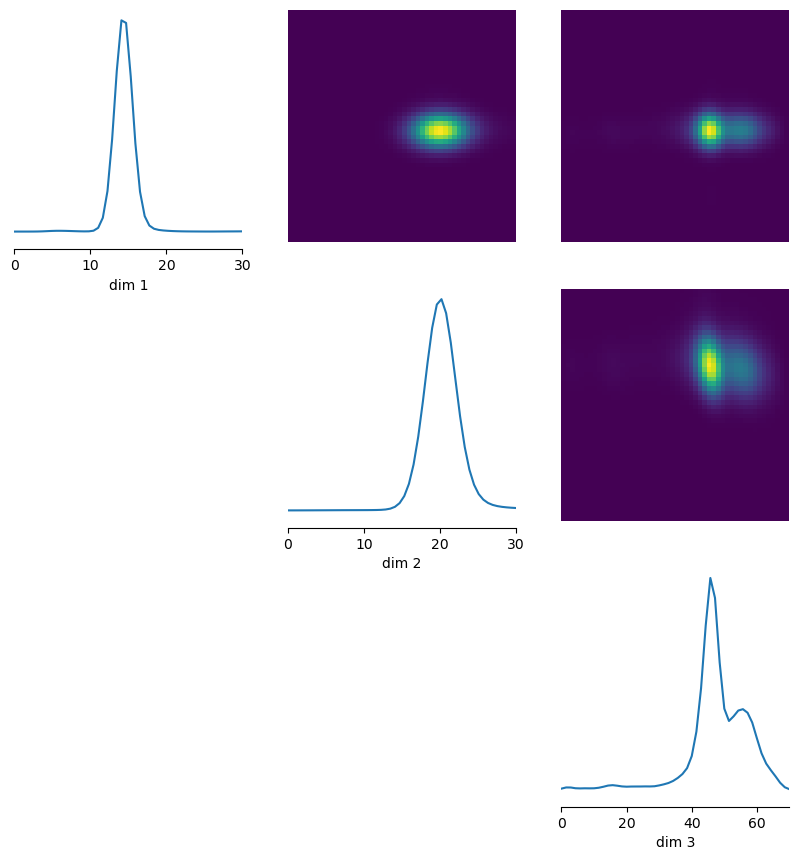

In [12]:
%matplotlib inline
from sbi.analysis.plot import pairplot

fig, out = pairplot(samples, limits=[[0,30],[0,30],[0,70]], fig_size=(3,3), upper='kde', diag='kde')

Plot the result of our inference

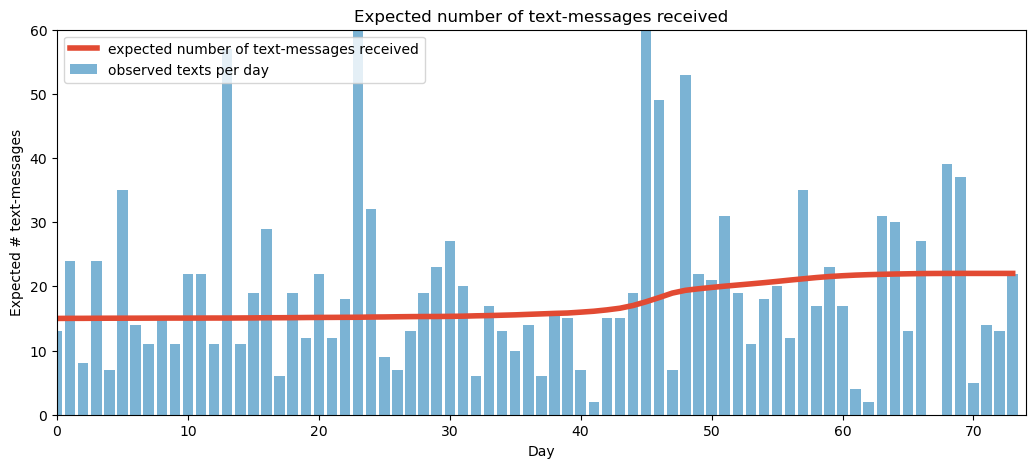

In [13]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < samples[:,2]
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (samples[ix,0].sum()
                                   + samples[~ix,1].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")

Now let us see how our results change if we use sequential inference instead of the amortized one. We choose to do it in two rounds an use the same observation in both

In [14]:
num_rounds = 2
# The specific observation we want to focus the inference on.

posteriors = []
proposal = prior
inference = SNPE(prior=prior, density_estimator="nsf")

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2500)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(observation)

Running 2500 simulations.:   0%|          | 0/2500 [00:00<?, ?it/s]

Running 2500 simulations.: 100%|██████████| 2500/2500 [00:00<00:00, 5427.25it/s]


 Neural network successfully converged after 143 epochs.

Drawing 2500 posterior samples: 2587it [00:00, 4234.39it/s]                          
Running 2500 simulations.: 100%|██████████| 2500/2500 [00:00<00:00, 4646.29it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.

Drawing 10000 posterior samples: 10583it [00:01, 7470.94it/s]                          


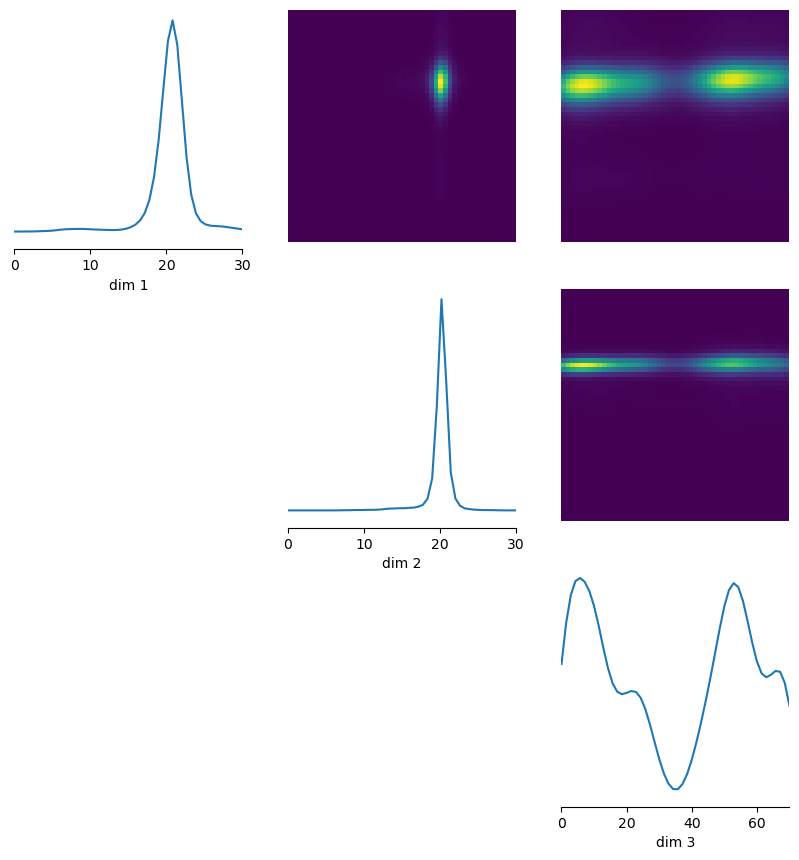

In [15]:
%matplotlib inline
from sbi.analysis.plot import pairplot
samples = posterior.sample((10000,), x=observation)
fig, out = pairplot(samples, limits=[[0,30],[0,30],[0,70]], fig_size=(3,3), upper='kde', diag='kde')


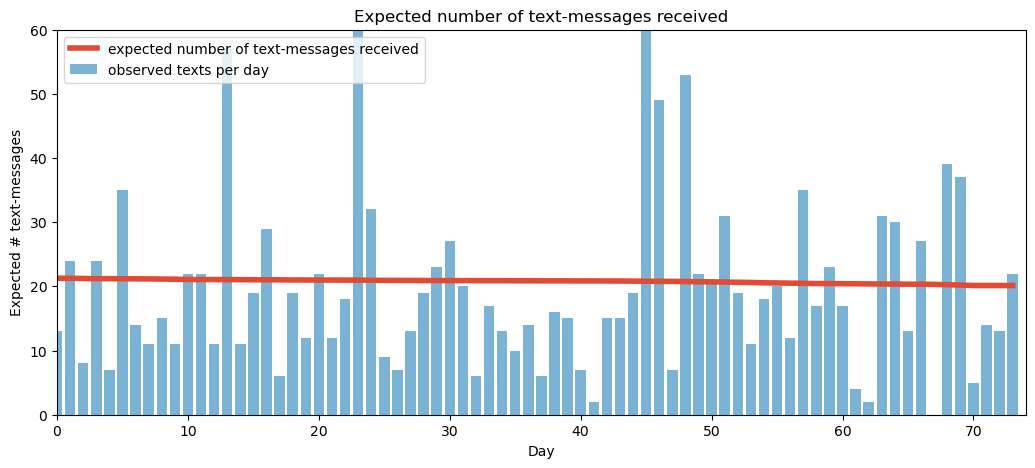

In [16]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < samples[:,2]
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (samples[ix,0].sum()
                                   + samples[~ix,1].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")